In [2]:
from PIL import Image
import tensorflow as tf
import os, glob, numpy as np
from sklearn.model_selection import train_test_split
import os, glob, numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
  except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
    print(e)

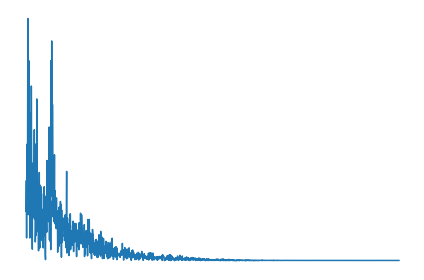

In [3]:

myFile = open("C:/Users/PC/표/sleep_file/새 폴더/EDF_Data/R/R_data/001_1.txt",'r')
lines = myFile.readlines()
n=len(lines)
text=[]
date=[] 
hour=[] 
mi=[]   
sec=[]
eeg=[]
eog=[]


for line in lines :
    text =line.split()
    date.append(text[0]) 
    hour.append(text[1])
    mi.append(text[2])
    sec.append(text[3])
    eeg.append(text[4])
    eog.append(text[5])
myFile.close()


fmax = 100      # 주파수 샘플링
dt = 1/fmax     # dt
N  = 3000    # 신호 길이

x=[]
y=[]
z=[]

for i in range(0,3000):
    x.append(i)
    y.append(eeg[i])
    z.append(eog[i])
              
y_a=[float(num) for num in y]
    
df = fmax/N
f = np.arange(0,N)*df
xf = np.fft.fft(y_a)*dt
plt.plot(f[0:int(N/2+1)],np.abs(xf[0:int(N/2+1)]))
plt.axis('off'), plt.xticks([]), plt.yticks([])
plt.grid()
plt.tight_layout()

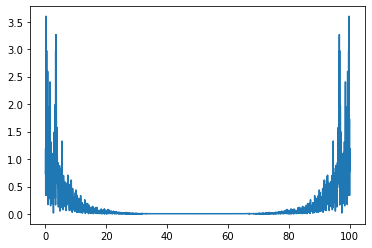

In [4]:
plt.plot(f,np.abs(xf))

(3000, 144, 216, 3)
3000
(1000, 144, 216, 3)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 144, 216, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 72, 108, 32)       0         
_________________________________________________________________
dropout (Dropout)            (None, 72, 108, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 108, 64)       18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (

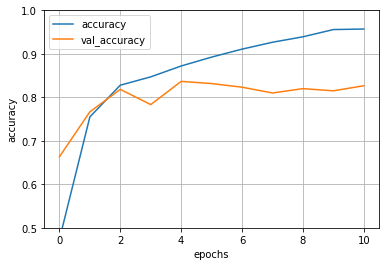

              precision    recall  f1-score   support

           0       0.77      0.48      0.59       144
           1       0.84      0.96      0.90       461
           2       0.99      1.00      1.00       233
           3       0.78      0.70      0.74       162

    accuracy                           0.86      1000
   macro avg       0.84      0.78      0.80      1000
weighted avg       0.85      0.86      0.85      1000

[[ 69  53   0  22]
 [  8 444   0   9]
 [  0   0 233   0]
 [ 13  34   2 113]]


In [1]:
from PIL import Image
import tensorflow as tf
import os, glob, numpy as np
from sklearn.model_selection import train_test_split
import os, glob, numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline 



# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   try:
#     for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
#       logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#       print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     print(e)

X_train, X_test, y_train, y_test = np.load("C:/Users/PC/표/cnn_eeg/sklearn_dataset2/eeg+eog.npy",allow_pickle=True)
print(X_train.shape)
print(X_train.shape[0])
print(X_test.shape)
# categories =["1_emg", "2_emg","3_emg","R_emg"]
categories =["1_eeg+eog","2_eeg+eog", "3_eeg+eog","R_eeg+eog"]
nb_classes = len(categories)

#일반화
X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255

# strategy = tf.distribute.MirroredStrategy()
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0","/gpu:1","/gpu:2","/gpu:3"],
                     cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

with mirrored_strategy.scope():
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding="same", input_shape=X_train.shape[1:], activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_dir = 'C:/Users/PC/표/model'

if not os.path.exists(model_dir):
    os.mkdir(model_dir)

model_path = model_dir + '/eeg'
checkpoint = ModelCheckpoint(filepath=model_path , monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=6)


model.summary()
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_split=0.2, callbacks=[checkpoint, early_stopping])
print("정확도 : %.4f" % (model.evaluate(X_test, y_test)[1]))
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))


model.save('model_eeg+eog')

# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = 'epochs'
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
# plt.legend(['loss','val_loss', 'accuracy','val_accuracy'])
plt.legend(['accuracy','val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim([0.5,1])
plt.grid()
plt.show()

from sklearn.metrics import classification_report,confusion_matrix

y_pred = model.predict(X_test)
y_test_class = np.argmax(y_test,axis=1)
y_pred_class = np.argmax(y_pred,axis=1)

print(classification_report(y_test_class,y_pred_class))
print(confusion_matrix(y_test_class,y_pred_class))


(3000, 144, 216, 3)
3000
(1000, 144, 216, 3)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 144, 216, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 72, 108, 32)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 72, 108, 32)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 72, 108, 64)       18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2

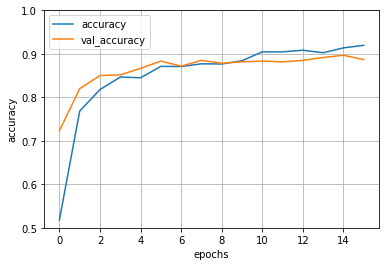

              precision    recall  f1-score   support

           0       0.78      0.48      0.60       147
           1       0.85      0.95      0.90       424
           2       0.96      0.97      0.97       225
           3       0.83      0.84      0.84       204

    accuracy                           0.86      1000
   macro avg       0.86      0.81      0.83      1000
weighted avg       0.86      0.86      0.86      1000

[[ 71  51   0  25]
 [  5 403   8   8]
 [  0   5 219   1]
 [ 15  17   0 172]]


In [2]:
from PIL import Image
import tensorflow as tf
import os, glob, numpy as np
from sklearn.model_selection import train_test_split
import os, glob, numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline 



# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   try:
#     for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
#       logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#       print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     print(e)

X_train, X_test, y_train, y_test = np.load("C:/Users/PC/표/cnn_eeg/sklearn_dataset2/eeg_fft+eog_fft.npy",allow_pickle=True)
print(X_train.shape)
print(X_train.shape[0])
print(X_test.shape)
# categories =["1_emg", "2_emg","3_emg","R_emg"]
categories =["1_eeg_fft+eog_fft","2_eeg_fft+eog_fft", "3_eeg_fft+eog_fft","R_eeg_fft+eog_fft"]
nb_classes = len(categories)

#일반화
X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255

# strategy = tf.distribute.MirroredStrategy()
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0","/gpu:1","/gpu:2","/gpu:3"],
                     cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

with mirrored_strategy.scope():
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding="same", input_shape=X_train.shape[1:], activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_dir = 'C:/Users/PC/표/model'

if not os.path.exists(model_dir):
    os.mkdir(model_dir)

model_path = model_dir + '/eeg'
checkpoint = ModelCheckpoint(filepath=model_path , monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=6)


model.summary()
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_split=0.2, callbacks=[checkpoint, early_stopping])
print("정확도 : %.4f" % (model.evaluate(X_test, y_test)[1]))
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))


model.save('model_eeg_fft+eog_fft')

# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
eeg_eog_fft_accuracy = history.history['accuracy']
eeg_eog_fft_val_accuracy = history.history['val_accuracy']
eeg_eog_fft_epochs = 'epochs'
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
# plt.legend(['loss','val_loss', 'accuracy','val_accuracy'])
plt.legend(['accuracy','val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim([0.5,1])
plt.grid()
plt.show()

from sklearn.metrics import classification_report,confusion_matrix

y_pred = model.predict(X_test)
y_test_class = np.argmax(y_test,axis=1)
y_pred_class = np.argmax(y_pred,axis=1)

print(classification_report(y_test_class,y_pred_class))
print(confusion_matrix(y_test_class,y_pred_class))


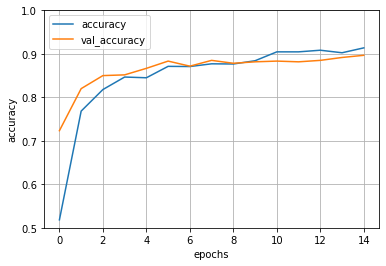

In [52]:
plt.plot(eeg_eog_fft_accuracy)
plt.plot(eeg_eog_fft_val_accuracy)
# plt.legend(['loss','val_loss', 'accuracy','val_accuracy'])
plt.legend(['accuracy','val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim([0.5,1])
plt.grid()
plt.show()

(3000, 144, 216, 3)
3000
(1000, 144, 216, 3)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 144, 216, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 72, 108, 32)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 72, 108, 32)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 108, 64)       18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2

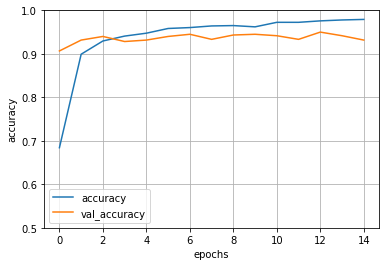

              precision    recall  f1-score   support

           0       0.78      0.91      0.84       158
           1       1.00      1.00      1.00       440
           2       1.00      1.00      1.00       212
           3       0.91      0.78      0.84       190

    accuracy                           0.94      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.95      0.94      0.94      1000

[[143   0   0  15]
 [  0 440   0   0]
 [  0   0 212   0]
 [ 41   0   0 149]]


In [3]:
from PIL import Image
import tensorflow as tf
import os, glob, numpy as np
from sklearn.model_selection import train_test_split
import os, glob, numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline 



# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   try:
#     for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
#       logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#       print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     print(e)

X_train, X_test, y_train, y_test = np.load("C:/Users/PC/표/cnn_eeg/sklearn_dataset2/eeg+eeg_fft+eog+eog_fft.npy",allow_pickle=True)
print(X_train.shape)
print(X_train.shape[0])
print(X_test.shape)
# categories =["1_emg", "2_emg","3_emg","R_emg"]
categories =["1+1","2+2", "3+3","R+R"]
nb_classes = len(categories)

#일반화
X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255

# strategy = tf.distribute.MirroredStrategy()
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0","/gpu:1","/gpu:2","/gpu:3"],
                     cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

with mirrored_strategy.scope():
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding="same", input_shape=X_train.shape[1:], activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_dir = 'C:/Users/PC/표/model'

if not os.path.exists(model_dir):
    os.mkdir(model_dir)

model_path = model_dir + '/eeg'
checkpoint = ModelCheckpoint(filepath=model_path , monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=6)


model.summary()
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_split=0.2, callbacks=[checkpoint, early_stopping])
print("정확도 : %.4f" % (model.evaluate(X_test, y_test)[1]))
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))


model.save('model_eeg+eeg_fft+eog+eog_fft')

# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
three_accuracy = history.history['accuracy']
three_val_accuracy = history.history['val_accuracy']
three_epochs = 'epochs'
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
# plt.legend(['loss','val_loss', 'accuracy','val_accuracy'])
plt.legend(['accuracy','val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim([0.5,1])
plt.grid()
plt.show()

from sklearn.metrics import classification_report,confusion_matrix

y_pred = model.predict(X_test)
y_test_class = np.argmax(y_test,axis=1)
y_pred_class = np.argmax(y_pred,axis=1)

print(classification_report(y_test_class,y_pred_class))
print(confusion_matrix(y_test_class,y_pred_class))


(3000, 144, 216, 3)
3000
(1000, 144, 216, 3)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 144, 216, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 72, 108, 32)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 72, 108, 32)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 108, 64)       18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2

Epoch 20/50
75/75 [==============================] - ETA: 0s - loss: 0.1702 - accuracy: 0.9321
Epoch 00020: val_loss did not improve from 0.31049
32/32 [==============================] - 0s 6ms/step - loss: 0.3379 - accuracy: 0.8830
정확도 : 0.8830
INFO:tensorflow:Assets written to: model_eeg_fft+eog_fft\assets


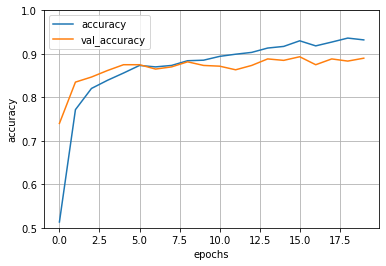

              precision    recall  f1-score   support

           0       0.76      0.64      0.69       147
           1       0.88      0.96      0.91       424
           2       0.98      0.98      0.98       225
           3       0.87      0.80      0.83       204

    accuracy                           0.88      1000
   macro avg       0.87      0.84      0.86      1000
weighted avg       0.88      0.88      0.88      1000

[[ 94  34   0  19]
 [  9 405   5   5]
 [  0   4 220   1]
 [ 21  19   0 164]]


In [3]:
from PIL import Image
import tensorflow as tf
import os, glob, numpy as np
from sklearn.model_selection import train_test_split
import os, glob, numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline 



# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   try:
#     for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
#       logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#       print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     print(e)

X_train, X_test, y_train, y_test = np.load("C:/Users/PC/표/cnn_eeg/sklearn_dataset2/eeg_fft+eog_fft.npy",allow_pickle=True)
print(X_train.shape)
print(X_train.shape[0])
print(X_test.shape)
# categories =["1_emg", "2_emg","3_emg","R_emg"]
categories =["1_eeg_fft+eog_fft","2_eeg_fft+eog_fft", "3_eeg_fft+eog_fft","R_eeg_fft+eog_fft"]
nb_classes = len(categories)

#일반화
X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255

# strategy = tf.distribute.MirroredStrategy()
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0","/gpu:1","/gpu:2","/gpu:3"],
                     cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

with mirrored_strategy.scope():
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding="same", input_shape=X_train.shape[1:], activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_dir = 'C:/Users/PC/표/model'

if not os.path.exists(model_dir):
    os.mkdir(model_dir)

model_path = model_dir + '/eeg'
checkpoint = ModelCheckpoint(filepath=model_path , monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=6)


model.summary()
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_split=0.2, callbacks=[checkpoint, early_stopping])
print("정확도 : %.4f" % (model.evaluate(X_test, y_test)[1]))
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))


model.save('model_eeg_fft+eog_fft')

# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
# plt.legend(['loss','val_loss', 'accuracy','val_accuracy'])
plt.legend(['accuracy','val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim([0.5,1])
plt.grid()
plt.show()

from sklearn.metrics import classification_report,confusion_matrix

y_pred = model.predict(X_test)
y_test_class = np.argmax(y_test,axis=1)
y_pred_class = np.argmax(y_pred,axis=1)

print(classification_report(y_test_class,y_pred_class))
print(confusion_matrix(y_test_class,y_pred_class))


# from sklearn.ensemble import VotingClassifier

In [ ]:
from PIL import Image
import tensorflow as tf
import os, glob, numpy as np
from sklearn.model_selection import train_test_split
import os, glob, numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
%matplotlib inline 



# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   try:
#     for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
#       logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#       print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     print(e)

X_train, X_test, y_train, y_test = np.load("C:/Users/PC/표/cnn_eeg/eog+eog_fft_4000.npy",allow_pickle=True)
print(X_train.shape)
print(X_train.shape[0])
# categories =["1_emg", "2_emg","3_emg","R_emg"]
categories =["1_eog+eog_fft","2_eog+eog_fft", "3_eog+eog_fft","R_eog+eog_fft"]
nb_classes = len(categories)

#일반화
X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255

# strategy = tf.distribute.MirroredStrategy()

# with strategy.scope():
model = Sequential()
model.add(Conv2D(32, (3,3), padding="same", input_shape=X_train.shape[1:], activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_dir = 'C:/Users/PC/표/model'

if not os.path.exists(model_dir):
    os.mkdir(model_dir)

model_path = model_dir + '/eog+eog_fft_test4000'
checkpoint = ModelCheckpoint(filepath=model_path , monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=6)


model.summary()
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_split=0.2, callbacks=[checkpoint, early_stopping])
print("정확도 : %.4f" % (model.evaluate(X_test, y_test)[1]))
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))


model.save('model_1')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['loss','val_loss', 'accuracy','val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

from sklearn.metrics import classification_report,confusion_matrix

y_pred = model.predict(X_test)
y_test_class = np.argmax(y_test,axis=1)
y_pred_class = np.argmax(y_pred,axis=1)

print(classification_report(y_test_class,y_pred_class))
print(confusion_matrix(y_test_class,y_pred_class))


In [ ]:
from tensorflow.keras.models import load_model
model = load_model('model_1')
model.summary()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['loss','val_loss', 'accuracy','val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()
print("정확도 : %.4f" % (model.evaluate(X_test, y_test)[1]))


In [ ]:
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
model_1 = load_model('model/eeg_fft_test2')
model_2 = load_model('model/eog_fft_test4000')


In [ ]:
model_1.summary()

In [ ]:
model_2.summary()

In [ ]:
print("정확도 : %.4f" % (model_1.evaluate(X_test, y_test)[1]))
print("정확도 : %.4f" % (model_2.evaluate(X_test, y_test)[1]))